<a href="https://colab.research.google.com/github/trangdtk-vnu/charging_stations/blob/main/parquet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [2]:
## Extract Spark folder in Colab folder ##
!tar zxvf "/content/spark-3.5.3-bin-hadoop3.tgz"


tar (child): /content/spark-3.5.3-bin-hadoop3.tgz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now


In [3]:

## Python library to locate and use Spark in Colab ##

!pip install -q findspark

In [4]:
## Set variables environment in Colab ##

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.3-bin-hadoop3"

import findspark
findspark.init()

## Check if all is working well ##
findspark.find()

'/content/spark-3.5.3-bin-hadoop3'

In [1]:
import pandas as pd
!pip install pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, when, col
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession.builder.appName("ReadParquetFile").getOrCreate()
df = spark.read.parquet("hypercarge_sessions.parquet")
df.show()

+------------+-----------------+------------------+--------------------+---------------+--------------------+----------------+---------------+--------------------+-------------+----------------+----------------+------------+----------+---------------+--------+----------------+-----------+--------+------------------------+-----------+---------------------+----------+-----------+------------------+---------------------------+--------------------------+--------------------+-----------------------+-------------------------+------------------+-----------------+--------------------+----------------------------+-----------+-----------------------+---------------------+--------------------+---------------+---------------------+-------------------+--------------------+-----------------------+--------------------------+------------------------+------------------+-----------------+------------------------+---------------+------------------------+-----------------------+-----------------+---------

In [3]:
df.printSchema()

root
 |-- serialNumber: string (nullable = true)
 |-- gpsLat: double (nullable = true)
 |-- gpsLong: double (nullable = true)
 |-- locationStreet: string (nullable = true)
 |-- locationZipCode: string (nullable = true)
 |-- locationTown: string (nullable = true)
 |-- locationProvince: string (nullable = true)
 |-- locationCountry: string (nullable = true)
 |-- locationUpdateNote: string (nullable = true)
 |-- endClientName: integer (nullable = true)
 |-- distributorName: string (nullable = true)
 |-- corporationName: string (nullable = true)
 |-- operatorName: integer (nullable = true)
 |-- lendeeName: integer (nullable = true)
 |-- evId: string (nullable = true)
 |-- type: string (nullable = true)
 |-- physicalPosition: long (nullable = true)
 |-- cableLength: long (nullable = true)
 |-- producer: string (nullable = true)
 |-- chargingSessionGraphData: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- currentEv: double (nullable = true)
 |    |    

Drop all NULL columns and repeated columns who have no contribute to futher data analysis.

In [4]:
df_cleaned = df.drop("endClientName","operatorName","lendeeName","producer","session.averageAmp","session.averagePinTempMinus"
                     ,"session.averagePinTempPlus","session.averagePower","session.analysisComment","session.analysisComment","session.analysisTimestamp",
                     "session.analyzedBy","session.errorCode","session.car","session.distributorName","session.distributorId","session.hasOcmfData","session.isNoStopTracked", "session.hycErrorcode","session.physicalPosition",
                     "session.peakAmp","session.peakPinTempMinus","session.peakPower","session.peakPinTempPlus", "session.producer",
                     "session.reason","session.stackErrorCount","session.stackErrorsArrayText","session.startU", "session.sessionErrorsDb",
                     "session.sessionLiveViewEnabled", "session.serialNumber", "session.stopU"," session.maxPinDelta", "session.transactionIdNew" ,
                     "carChargeParameter","carChargeParameter.batteryCapacity" ,"session.type" ,"session.maxPinDelta", "locationCountry","distributorName",
                     "corporationName","hasOcmfData","session.falsePositive","session.logRequestExecuted","session.logRequestResult","session.softwareVersion",
                     "session.timestampUncertain","carChargeParameter.excludeFromStatistics"
                     )
df_cleaned.show()

+------------+-----------------+------------------+--------------------+---------------+--------------------+----------------+--------------------+---------------+--------+----------------+-----------+------------------------+-----------+---------------------+----------+--------------------+----------------------------+--------------------+---------------+------------------+-----------------+--------------------+----------------+---------------+-------------------------+----------------+---------------------------------------+--------------------------+---------------------------+--------------------------+----------------------+-----------------+
|serialNumber|           gpsLat|           gpsLong|      locationStreet|locationZipCode|        locationTown|locationProvince|  locationUpdateNote|           evId|    type|physicalPosition|cableLength|chargingSessionGraphData|stackErrors|chargingSessionErrors|stackOszis|session.creationTime|session.carChargeParameterId|         session.end|  

In [5]:
df_cleaned.printSchema()

root
 |-- serialNumber: string (nullable = true)
 |-- gpsLat: double (nullable = true)
 |-- gpsLong: double (nullable = true)
 |-- locationStreet: string (nullable = true)
 |-- locationZipCode: string (nullable = true)
 |-- locationTown: string (nullable = true)
 |-- locationProvince: string (nullable = true)
 |-- locationUpdateNote: string (nullable = true)
 |-- evId: string (nullable = true)
 |-- type: string (nullable = true)
 |-- physicalPosition: long (nullable = true)
 |-- cableLength: long (nullable = true)
 |-- chargingSessionGraphData: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- currentEv: double (nullable = true)
 |    |    |-- currentEvse: double (nullable = true)
 |    |    |-- currentMax: double (nullable = true)
 |    |    |-- date: string (nullable = true)
 |    |    |-- dcMinus: double (nullable = true)
 |    |    |-- dcPlus: double (nullable = true)
 |    |    |-- resistance: long (nullable = true)
 |    |    |-- soc: long (nu

In [6]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_json, from_json
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, LongType, BooleanType, ArrayType

# Initialize Spark session
spark = SparkSession.builder.appName('TestParquetLoad').getOrCreate()

# Load the Parquet dataset
df = spark.read.parquet('hypercarge_sessions.parquet')

# Define schemas for nested fields
charging_session_graph_data_schema = ArrayType(
    StructType([
        StructField("currentEv", DoubleType()),
        StructField("currentEvse", DoubleType()),
        StructField("currentMax", DoubleType()),
        StructField("date", StringType()),
        StructField("dcMinus", DoubleType()),
        StructField("dcPlus", DoubleType()),
        StructField("resistance", DoubleType()),
        StructField("soc", DoubleType()),
        StructField("voltageEv", DoubleType()),
        StructField("voltageEvse", DoubleType())
    ])
)

charging_session_errors_schema = ArrayType(
    StructType([
        StructField("cause", StringType()),
        StructField("chargingSessionErrorsId", LongType()),
        StructField("chargingSessionId", LongType()),
        StructField("dateTime", StringType()),
        StructField("errorCode", StringType()),
        StructField("hycErrorCode", StringType()),
        StructField("isPrivate", BooleanType())
    ])
)

# Cast the columns to the defined schemas (if they exist in the dataset)
if 'chargingSessionGraphData' in df.columns:
    df = df.withColumn("chargingSessionGraphData", col("chargingSessionGraphData").cast(charging_session_graph_data_schema))

if 'chargingSessionErrors' in df.columns:
    df = df.withColumn("chargingSessionErrors", col("chargingSessionErrors").cast(charging_session_errors_schema))

# Show the cleaned DataFrame
df_cleaned.show(5, truncate=False)


+------------+-----------------+------------------+-------------------------------+---------------+---------------------------+----------------+-----------------------+---------------+--------+----------------+-----------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [7]:
from pyspark.sql.functions import explode

df_csgraphdata = df.withColumn("chargingSessionGraphData_exploded", explode(col("chargingSessionGraphData")))

# Select the fields inside the struct
df_csgraphdata = df_csgraphdata.select(
    "serialNumber",  # Select any additional columns you need
    "chargingSessionGraphData_exploded.*"
)

# Show the exploded DataFrame
df_csgraphdata.show(5, truncate=False)



+------------+---------+-----------+----------+-----------------------+-------+------+----------+----+---------+-----------+
|serialNumber|currentEv|currentEvse|currentMax|date                   |dcMinus|dcPlus|resistance|soc |voltageEv|voltageEvse|
+------------+---------+-----------+----------+-----------------------+-------+------+----------+----+---------+-----------+
|22BZ3013B   |0.0      |0.0        |500.0     |2024-07-14 06:01:57.926|42.0   |42.0  |1813.0    |37.0|408.0    |349.3      |
|22BZ3013B   |81.6     |76.8       |500.0     |2024-07-14 06:02:02.046|42.0   |42.0  |797.0     |37.0|408.0    |352.3      |
|22BZ3013B   |162.0    |157.6      |500.0     |2024-07-14 06:02:06.076|42.0   |42.0  |1233.0    |37.0|408.0    |355.7      |
|22BZ3013B   |243.0    |238.3      |500.0     |2024-07-14 06:02:10.126|41.2   |42.0  |1245.0    |37.0|408.0    |359.3      |
|22BZ3013B   |324.0    |319.1      |500.0     |2024-07-14 06:02:14.176|41.4   |42.0  |1250.0    |37.0|408.0    |363.0      |


In [8]:
from pyspark.sql import functions as F

In [9]:
df_stackerror = df.withColumn("stackErrors_exploded", explode(col("stackErrors")))

# Select the fields inside the struct
df_stackerror = df_stackerror.select(
    "serialNumber",  # Select any additional columns you need
    "stackErrors_exploded.*"  # This expands all the fields from the struct
)

# Show the exploded DataFrame
df_stackerror.show(5, truncate=False)



+------------+-------------+-----------------+-------------+-----------------+-----------------------------+
|serialNumber|errorPosition|errorText        |stackPosition|stackSerialNumber|ts                           |
+------------+-------------+-----------------+-------------+-----------------+-----------------------------+
|22BZ0677B   |1            |VOLTAGE_ZKC_ASYM |0            |25498            |2024-07-14T08:28:29.342+00:00|
|22BZ0683B   |2            |CPLD_OVERVOLT_ZKH|1            |25766            |2024-07-14T09:07:57.461+00:00|
|22BZ0683B   |1            |NOTREADY_V       |0            |29109            |2024-07-14T09:07:57.461+00:00|
|22BZ0683B   |2            |CPLD_PFC_FAULT   |0            |29109            |2024-07-14T09:07:57.461+00:00|
|22BZ0683B   |2            |CPLD_OVERVOLT_ZKH|0            |29109            |2024-07-14T09:07:57.461+00:00|
+------------+-------------+-----------------+-------------+-----------------+-----------------------------+
only showing top 5 

In [10]:
df_csserrors = df.withColumn("chargingSessionErrors_exploded", explode(col("chargingSessionErrors")))

# Select the fields inside the struct
df_csserrors = df_csserrors.select(
    "serialNumber",  # Select any additional columns you need
    "chargingSessionErrors_exploded.*"  # This expands all the fields from the struct
)

# Show the exploded DataFrame
df_csserrors.show(5, truncate=False)

+------------+----------+-----------------------+-----------------+-----------------------------+---------+-------------------------------------+---------+
|serialNumber|cause     |chargingSessionErrorsId|chargingSessionId|dateTime                     |errorCode|hycErrorCode                         |isPrivate|
+------------+----------+-----------------------+-----------------+-----------------------------+---------+-------------------------------------+---------+
|22BZ3013B   |loganalyze|0                      |69206115         |2024-07-14T06:26:31.833+00:00|NULL     |PostAnalysis_User_stop_charger_button|true     |
|22BZ3013B   |loganalyze|0                      |69206115         |2024-07-14T06:26:33.372+00:00|NULL     |PostAnalysis_user_stop_ev_side       |true     |
|22BZ3013B   |loganalyze|0                      |69206115         |2024-07-14T06:26:34.302+00:00|NULL     |PostAnalysis_EV_stop_during_init     |true     |
|21BZ3104B   |loganalyze|0                      |69206119       

In [11]:
df_stacksize = df.withColumn("stackOszis_exploded", explode(col("stackOszis")))

# Select the fields inside the struct
df_stacksize = df_stacksize.select(
    "__index_level_0__",  # Select any additional columns you need
    "stackOszis_exploded.*"  # This expands all the fields from the struct
)

# Show the exploded DataFrame
df_stacksize.show(5, truncate=False)

+-----------------+---------------+-----------------+----------+------------+----+--------------------+--------+-------------------+---------+-----------------+-------+------------+----+---------+----+-------------+------------+-------+---------------+---------+------------------+----------+---------+----+--------------+---------+--------+---------------+------+------------+--------+-------+---------------+---------------+-------------------+---------------+-----------------+--------------+-------------------+-----------+-----+------+-----+-----+----------------+
|__index_level_0__|analysisComment|analysisTimeStamp|analyzedBy|averagePower|car |carchargeparameterId|category|categoryDescription|chargerId|chargingSessionId|chassis|creationTime|end |errorCode|evId|falsePositive|hycErrorCode|isFault|isNoStopTracked|isWarning|logRequestExecuted|meterStart|meterStop|note|outletPosition|peakPower|position|pwrUnitPosition|reason|serialNumber|socStart|socStop|softwareVersion|stackErrorCount|stac

In [12]:
print(df_stacksize.columns)

['__index_level_0__', 'analysisComment', 'analysisTimeStamp', 'analyzedBy', 'averagePower', 'car', 'carchargeparameterId', 'category', 'categoryDescription', 'chargerId', 'chargingSessionId', 'chassis', 'creationTime', 'end', 'errorCode', 'evId', 'falsePositive', 'hycErrorCode', 'isFault', 'isNoStopTracked', 'isWarning', 'logRequestExecuted', 'meterStart', 'meterStop', 'note', 'outletPosition', 'peakPower', 'position', 'pwrUnitPosition', 'reason', 'serialNumber', 'socStart', 'socStop', 'softwareVersion', 'stackErrorCount', 'stackOsziDateTime', 'stackOsziEvents', 'stackSerialNumber', 'stackSwVersion', 'stackosziCategoryId', 'stackosziId', 'start', 'startU', 'stopI', 'stopU', 'transactionIdNew']


In [13]:
df_stacksize0 = df_stacksize.dropna(how='any')
df_stacksize0.show(5, truncate=False)

+-----------------+---------------+-----------------+----------+------------+---+--------------------+--------+-------------------+---------+-----------------+-------+------------+---+---------+----+-------------+------------+-------+---------------+---------+------------------+----------+---------+----+--------------+---------+--------+---------------+------+------------+--------+-------+---------------+---------------+-----------------+---------------+-----------------+--------------+-------------------+-----------+-----+------+-----+-----+----------------+
|__index_level_0__|analysisComment|analysisTimeStamp|analyzedBy|averagePower|car|carchargeparameterId|category|categoryDescription|chargerId|chargingSessionId|chassis|creationTime|end|errorCode|evId|falsePositive|hycErrorCode|isFault|isNoStopTracked|isWarning|logRequestExecuted|meterStart|meterStop|note|outletPosition|peakPower|position|pwrUnitPosition|reason|serialNumber|socStart|socStop|softwareVersion|stackErrorCount|stackOsziD

In [14]:
df_cleaned = df_cleaned.drop("stackOszis")
df_cleaned.show()

+------------+-----------------+------------------+--------------------+---------------+--------------------+----------------+--------------------+---------------+--------+----------------+-----------+------------------------+-----------+---------------------+--------------------+----------------------------+--------------------+---------------+------------------+-----------------+--------------------+----------------+---------------+-------------------------+----------------+---------------------------------------+--------------------------+---------------------------+--------------------------+----------------------+-----------------+
|serialNumber|           gpsLat|           gpsLong|      locationStreet|locationZipCode|        locationTown|locationProvince|  locationUpdateNote|           evId|    type|physicalPosition|cableLength|chargingSessionGraphData|stackErrors|chargingSessionErrors|session.creationTime|session.carChargeParameterId|         session.end|   session.evId|session.

In [15]:
df_cleaned.printSchema()

root
 |-- serialNumber: string (nullable = true)
 |-- gpsLat: double (nullable = true)
 |-- gpsLong: double (nullable = true)
 |-- locationStreet: string (nullable = true)
 |-- locationZipCode: string (nullable = true)
 |-- locationTown: string (nullable = true)
 |-- locationProvince: string (nullable = true)
 |-- locationUpdateNote: string (nullable = true)
 |-- evId: string (nullable = true)
 |-- type: string (nullable = true)
 |-- physicalPosition: long (nullable = true)
 |-- cableLength: long (nullable = true)
 |-- chargingSessionGraphData: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- currentEv: double (nullable = true)
 |    |    |-- currentEvse: double (nullable = true)
 |    |    |-- currentMax: double (nullable = true)
 |    |    |-- date: string (nullable = true)
 |    |    |-- dcMinus: double (nullable = true)
 |    |    |-- dcPlus: double (nullable = true)
 |    |    |-- resistance: long (nullable = true)
 |    |    |-- soc: long (nu

In [16]:
# Get numeric columns only
numeric_columns = [field.name for field in df_cleaned.schema.fields if str(field.dataType) in ['IntegerType', 'DoubleType', 'FloatType', 'LongType']]

# Apply describe to numeric columns
df_cleaned.select(numeric_columns).describe().show()

+-------+
|summary|
+-------+
|  count|
|   mean|
| stddev|
|    min|
|    max|
+-------+



In [17]:
# Calculate session frequency per vehicle (evId)
session_frequency = df_cleaned.groupBy("evId").agg(F.count("serialNumber").alias("session_frequency"))

# Show the result
session_frequency.show(10, truncate=False)

+---------------+-----------------+
|evId           |session_frequency|
+---------------+-----------------+
|168145231922987|2                |
|242185271279925|4                |
|26717617501206 |3                |
|79261807937232 |2                |
|541065806873   |1                |
|277783353426023|1                |
|79376146350786 |1                |
|246354509075236|1                |
|277783353001198|1                |
|168145233321196|2                |
+---------------+-----------------+
only showing top 10 rows



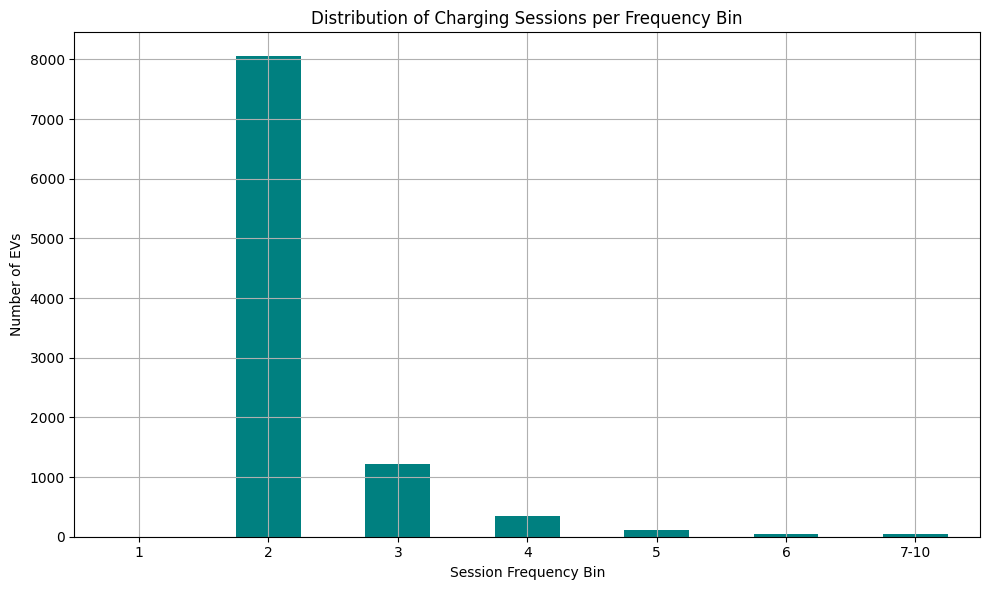

In [26]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming session_frequency_pd is loaded with 'evId' and 'session_frequency'
session_frequency_pd = session_frequency.toPandas()

# Define bins and labels for the session frequency
bins = [0, 1, 2, 3, 4, 5, 6, 10]  # Adjust the last bin to include all values from 7 to 10
labels = ['1', '2', '3', '4', '5', '6', '7-10']

# Create a new column 'Frequency Bin' based on 'session_frequency'
session_frequency_pd['Frequency Bin'] = pd.cut(session_frequency_pd['session_frequency'],
                                               bins=bins,
                                               labels=labels,
                                               include_lowest=True,
                                               right=False)

# Group by the new 'Frequency Bin' and count the number of EVs
frequency_distribution = session_frequency_pd['Frequency Bin'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(10, 6))
frequency_distribution.plot(kind='bar', color='teal')
plt.title('Distribution of Charging Sessions per Frequency Bin')
plt.xlabel('Session Frequency Bin')
plt.ylabel('Number of EVs')
plt.xticks(rotation=0)  # Set rotation to 0 for better readability
plt.grid(True)
plt.tight_layout()
plt.show()


In [19]:
# Group by gpsLat and gpsLong to count charging sessions at each location
location_behavior = df_cleaned.groupBy("gpsLat", "gpsLong").agg(F.count("serialNumber").alias("session_count"))

# Show the result
location_behavior.show(10, truncate=False)


+-----------------+-----------------+-------------+
|gpsLat           |gpsLong          |session_count|
+-----------------+-----------------+-------------+
|41.092773        |16.777855        |78           |
|41.23408         |14.09174         |30           |
|44.96265         |9.90435          |87           |
|44.6216434       |11.4203974       |40           |
|44.66229         |10.85801         |140          |
|44.96296017659537|9.906183880356323|143          |
|43.65052         |11.46448         |106          |
|40.0             |-39.0            |24           |
|41.068329        |14.88722         |30           |
|44.6763717       |8.6581214        |71           |
+-----------------+-----------------+-------------+
only showing top 10 rows



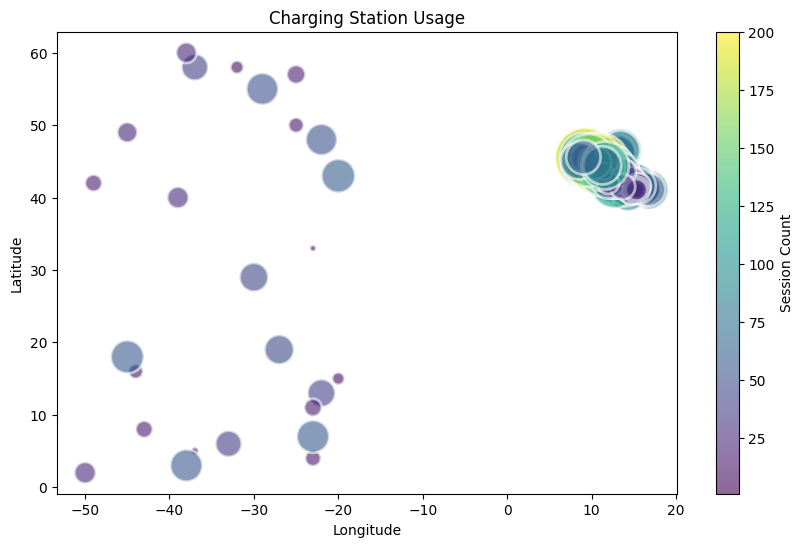

In [20]:
# Assuming 'location_behavior' DataFrame has been calculated
location_behavior = df_cleaned.groupBy("gpsLat", "gpsLong").count().withColumnRenamed("count", "session_count")

# Convert to pandas DataFrame for plotting
location_behavior_pd = location_behavior.toPandas()

# Scatter plot of charging stations by session count
plt.figure(figsize=(10, 6))
plt.scatter(location_behavior_pd['gpsLong'], location_behavior_pd['gpsLat'],
            s=location_behavior_pd['session_count']*10,  # Size by session count
            c=location_behavior_pd['session_count'], cmap='viridis', alpha=0.6, edgecolors="w", linewidth=2)
plt.colorbar(label='Session Count')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Charging Station Usage')
plt.show()


In [36]:
!pip install plotly


import plotly.express as px
import pandas as pd

location_behavior_pd = location_behavior.toPandas()
# Ensure that the DataFrame is in the expected format with columns ['gpsLat', 'gpsLong', 'session_count']

# Create a geographical scatter plot focused on Italy
fig = px.scatter_geo(location_behavior_pd,
                     lat='gpsLat',
                     lon='gpsLong',
                     color="session_count",  # Color of markers will reflect the session count
                     size="session_count",  # Size of markers will also reflect session count
                     projection="natural earth",  # Type of the map projection
                     title='Charging Station Usage in Italy',
                     hover_name='session_count',  # Shows session count on hover
                     hover_data={'gpsLat': True, 'gpsLong': True, 'session_count': True},
                     size_max=50,  # Adjust the max size to control marker sizes
                     scope="europe",  # Limit the map scope to Europe
                     center={"lat": 41.9028, "lon": 12.4964})  # Center the map on Rome, Italy

# Update layout to refine the map presentation
fig.update_geos(
    visible=False,  # Hide the default basemap
    showcountries=True,  # Show country borders
    countrycolor="RebeccaPurple"  # Use a custom color for country borders
)

fig.update_layout(
    geo=dict(
        showland=True,  # Ensure land is shown
        landcolor="lightgray",
        showcountries=True,  # Countries are shown
        countrycolor="black",  # Country borders are black
        lataxis_range=[35, 48],  # latitude range to zoom in on Italy
        lonaxis_range=[6, 19],  # longitude range to zoom in on Italy
    ),
    margin={"r":0,"t":0,"l":0,"b":0}  # Reduce the space around the plot
)

# Show the figure
fig.show()



In [27]:
# Calculate the number of distinct charging stations visited by each evId
return_rate = df_cleaned.groupBy("evId").agg(F.countDistinct("serialNumber").alias("unique_stations"))

# Show the result
return_rate.show(20, truncate=False)


+---------------+---------------+
|evId           |unique_stations|
+---------------+---------------+
|541065834241   |1              |
|246354509075236|1              |
|277783353737381|1              |
|180680382547707|1              |
|13773004270751 |2              |
|79376146350786 |1              |
|4833532760833  |1              |
|180680382655511|2              |
|277783353565137|1              |
|168145234571280|1              |
|541065641227   |1              |
|180680382640610|1              |
|158409692327000|1              |
|263882790680774|3              |
|277783353426023|1              |
|277783353025827|1              |
|79261807937232 |2              |
|103669855026   |1              |
|168145231922987|2              |
|168145233475388|1              |
+---------------+---------------+
only showing top 20 rows



In [23]:
# Group by province to see the number of sessions by region
region_utilization = df_cleaned.groupBy("locationProvince").agg(F.count("serialNumber").alias("session_count"))

# Show the result
region_utilization.orderBy(F.desc("session_count")).show(10, truncate=False)


+----------------+-------------+
|locationProvince|session_count|
+----------------+-------------+
|NULL            |4511         |
|Emilia-Romagna  |2465         |
|Lombardia       |1538         |
|Lazio           |814          |
|Toscana         |642          |
|Lombardy        |608          |
|Liguria         |521          |
|Campania        |502          |
|Piemonte        |397          |
|Puglia          |311          |
+----------------+-------------+
only showing top 10 rows



In [24]:
# Explode the stackErrors array and count how many faults occur in charging sessions
fault_analysis = df_cleaned.withColumn("error", F.explode_outer("stackErrors")).groupBy("error.errorText").agg(
    F.count("serialNumber").alias("error_count")
)

# Show the most common errors
fault_analysis.orderBy(F.desc("error_count")).show(10, truncate=False)


+-----------------------+-----------+
|errorText              |error_count|
+-----------------------+-----------+
|NULL                   |13240      |
|DC-LINK_DAB            |151        |
|CPLD_PFC_FAULT         |99         |
|VOLTAGE_ZKC_ASYM       |91         |
|CPLD_DCAC_FAULT        |71         |
|CPLD_OVERVOLT_ZKL      |52         |
|FAULT_B                |39         |
|CPLD_OVERVOLT_ZKH      |37         |
|OUTPUT_UNDERVOLTAGE_DAB|32         |
|FAULT_C                |30         |
+-----------------------+-----------+
only showing top 10 rows



In [32]:
# Group by user (evId) to calculate the number of sessions
user_charging_behavior = df_cleaned.groupBy("evId").agg(F.count("serialNumber").alias("session_count"))

# Segment users into frequent and infrequent chargers
user_charging_behavior = user_charging_behavior.withColumn(
    "user_segment",
    F.when(F.col("session_count") >= 10, "Frequent")
    .when((F.col("session_count") >= 5) & (F.col("session_count") < 10), "Occasional")
    .otherwise("Infrequent")
)

# Count how many users fall into each segment
user_segments = user_charging_behavior.groupBy("user_segment").agg(F.count("evId").alias("user_count"))

# Show the result
user_segments.show(truncate=False)


+------------+----------+
|user_segment|user_count|
+------------+----------+
|Frequent    |10        |
|Occasional  |83        |
|Infrequent  |9740      |
+------------+----------+



In [33]:
# Count the number of errors per charging station (by gpsLat and gpsLong)
error_analysis = df_cleaned.withColumn("error", F.explode_outer("stackErrors")).groupBy("gpsLat", "gpsLong").agg(
    F.count("error.errorText").alias("error_count"),
    F.collect_list("error.errorText").alias("error_list")
)

# Show charging stations with the most errors
error_analysis.orderBy(F.desc("error_count")).show(10, truncate=False)

# This can be extended with machine learning to predict when stations will need maintenance.


+------------------+------------------+-----------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [34]:
# Count the number of unique stations each user has visited
user_retention = df_cleaned.groupBy("evId").agg(F.countDistinct("serialNumber").alias("unique_stations"))

# Identify loyal users who frequently return to the same station
loyal_users = user_retention.filter(F.col("unique_stations") == 1)

# Show loyal users
loyal_users.show(10, truncate=False)


+---------------+---------------+
|evId           |unique_stations|
+---------------+---------------+
|541065834241   |1              |
|246354509075236|1              |
|277783353737381|1              |
|180680382547707|1              |
|79376146350786 |1              |
|4833532760833  |1              |
|277783353565137|1              |
|168145234571280|1              |
|541065641227   |1              |
|180680382640610|1              |
+---------------+---------------+
only showing top 10 rows

